In [1]:
import numpy as np
import qutip as qt
import scipy
import matplotlib
import matplotlib.pylab as plt
import krotov
import os.path
import random

from matplotlib import rc
rc('font',**{'family':'serif','serif':['Computer Modern'], 'size':25})
rc('text', usetex=True)
plt.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]

C:\Users\esttm\AppData\Local\Temp\ipykernel_4728\1267948679.py:13: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  plt.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]


In [2]:
rank = 2 # rank of hamiltonian
kets = [qt.basis(2,i) for i in range(rank)]
projs = [qt.ket2dm(ket) for ket in kets]
c_ops =[]
psi0 = qt.fock(2,0)

e = 1.6e-19 #coulomb
h = 6.63e-34 *1e12/ e #eV ps
hbar = 1
hbar_eV = 6.582e-16 * 1e12 #eV ps
c = 3e8 * 1e-10 # cm/ps

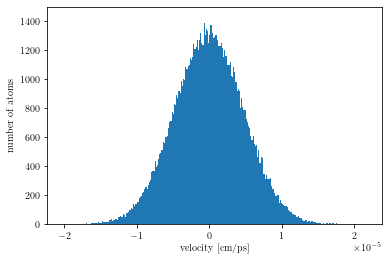

In [3]:
random.seed(0)
N_atoms = int(1e5)

T = 300 #K temperature of cloud
m = 2*9.1e-31 #kg
k = 1.38e-23 # [J K^-1]
std_deviation = np.sqrt(k*T/m) #standard deviation of gaussian
amplitude = np.sqrt(m/(2*np.pi*k*T))

velocities = np.random.normal(loc=0,scale=std_deviation,size=N_atoms) *1e-10#cm/ps

N_bins = 267 #calculated such that 1 bin is the equivalent of 1 unit of photon momentum for Ps
hist = plt.hist(velocities,bins=N_bins)

plt.ylim(0,1500)
plt.xlabel("velocity [cm/ps]")
plt.ylabel("number of atoms")
plt.show()

In [4]:
populations = hist[0]
velocity_bins = np.asarray([ hist[1][i] for i in range(N_bins)] )
# create new vector to track population: (velocity , population,) for cooling
states = np.asarray([velocity_bins,populations])

In [5]:
endTime =  20 #ps 
mass_ps = 1.022e6 # eV/ c^2 
wavelength = 243e-7 #cm
wavenumber = 2*np.pi/wavelength
momentum_per_photon = hbar_eV*wavenumber #eV ps cm^-1
velocity_change_per_photon = momentum_per_photon / mass_ps *c**2 #  cm/ps
print(velocity_change_per_photon, "cm/ps")
energy_splitting =  h*c/wavelength
omega0 = energy_splitting / hbar / hbar_eV# radians ps^-1
period = wavelength/c

binwidth = 2*np.pi/omega0*100
N_time = int(endTime/binwidth)
tlist = np.linspace(0,endTime,N_time)


pulse_duration = 10 #ps
tcentre = 10 #ps
tlist_centre = np.full(N_time,tcentre)

1.498728915411178e-07 cm/ps


In [6]:
def evolve(omega0,detuning,chirp,rabi0,pulse_duration):
    
    rabi = lambda t, args: rabi0 * np.exp(-4*np.log(2)*(t-tcentre)**2/pulse_duration**2)
    final_states = []
    for vel in velocity_bins:
        H0 = hbar*qt.Qobj([[0,0],[0,omega0*vel/c +detuning*(1+vel/c)]])
        H_chirp = hbar*qt.Qobj([[0,0],[0,chirp*(1+vel/c)]])
        H_transition = 0.5*hbar*qt.sigmax()
        H = [H0,[H_chirp,tlist-tlist_centre],[H_transition,rabi]]

        result = qt.mesolve(H, psi0,tlist,c_ops,e_ops=projs)
        current_state = qt.Qobj([[result.expect[0][-1]],[result.expect[1][-1]]])
        final_states.append(current_state)
    
    return final_states 

In [7]:
rabi0 = 2*np.pi*(200e-3) #THz
detuning = 2*np.pi*(-152e-3) #THz
chirp = 2*np.pi*(50e-3) #THz/ps

In [25]:
final_states = evolve(omega0,detuning,chirp,rabi0,pulse_duration) 

In [26]:
print(np.abs(final_states[2][1]))

[[0.00028328]]


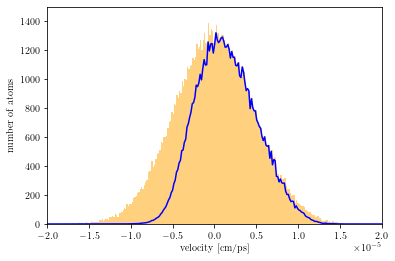

In [27]:
final_pops = np.asarray([np.abs(final_states[i][1][0][0]) for i in range(len(final_states))])
hist = plt.hist(velocities,bins=N_bins,alpha=0.5,color="orange")
plt.xlabel("velocity [cm/ps]")
plt.ylabel("number of atoms")
plt.ylim(0,1500)
plt.xlim(-2e-5,2e-5)
plt.plot(velocity_bins,final_pops*populations,color="blue")
plt.show()

In [28]:
# Take initial states of atoms and change the population in each velocity class due to photon momentum transfer
# for a proof of concept, assume the laser is going in the negative direction
# For hte full method, might have to decide which direction to scan through the states depending on which direction the photon is coming from.
def update_states(states, transitions):
    temp_states = states
    new_states = np.zeros((2,N_bins))
    for i in range(1,N_bins-1):
        initial_population = temp_states[1][i]
        new_states[1][i] = initial_population*(1-transitions[i]) + temp_states[1][i+1]*transitions[i+1]
    return new_states


In [29]:
states_after_one_pulse = update_states(states,final_pops)

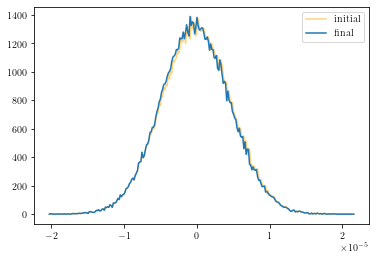

In [30]:
plt.plot(velocity_bins,states[1],color="orange",alpha=0.50, label="initial")
plt.plot(velocity_bins,states_after_one_pulse[1], label="final")
plt.legend()
plt.show()

In [36]:
def evolve_train(omega0,detuning,chirp,rabi0,pulse_duration,previous_states):
    rabi = lambda t, args: rabi0 * np.exp(-4*np.log(2)*(t-tcentre)**2/pulse_duration**2)
    new_states = []
    size = velocity_bins.size
    #print(previous_states)
    for i in range(size):
        initial_state = qt.Qobj(previous_states[i])
        vel = velocity_bins[i]
        print(initial_state)    
        H0 = hbar*qt.Qobj([[0,0],[0,omega0*vel/c +detuning*(1+vel/c)]])
        H_chirp = hbar*qt.Qobj([[0,0],[0,chirp*(1+vel/c)]])
        H_transition = 0.5*hbar*qt.sigmax()
        H = [H0,[H_chirp,tlist-tlist_centre],[H_transition,rabi]]

        result = qt.mesolve(H, initial_state,tlist,c_ops,e_ops=projs)
        new_states.append(result.expect[1][-1])
    
    return new_states 

In [37]:
final_states2 = evolve_train(omega0,detuning,chirp,rabi0,pulse_duration,final_states) 



[Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[9.99883055e-01]
 [1.16945278e-04]], Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[9.99795946e-01]
 [2.04053592e-04]], Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[9.99716721e-01]
 [2.83278662e-04]], Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[9.99692609e-01]
 [3.07391353e-04]], Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[9.99737683e-01]
 [2.62316536e-04]], Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[9.99822775e-01]
 [1.77224570e-04]], Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[9.99892245e-01]
 [1.07755262e-04]], Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[9.99898049e-01]
 [1.01951430e-04]], Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[9.99830299e-01]
 [1.6970067

In [34]:
print(final_states2[1])

0.00020186715405046222


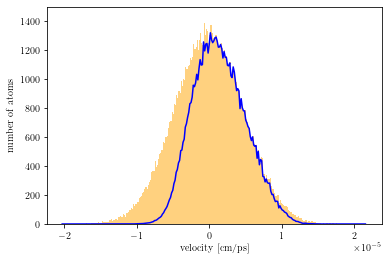

In [35]:
final_pops2 = np.asarray([np.abs(final_states2[i]) for i in range(len(final_states2))])
hist = plt.hist(velocities,bins=N_bins,alpha=0.5,color="orange")
plt.xlabel("velocity [cm/ps]")
plt.ylabel("number of atoms")
plt.ylim(0,1500)
plt.plot(velocity_bins,final_pops*populations,color="blue")
plt.show()